In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
import mdn
import plotly.express as px

from sim import generate, moving_average

/Users/mohamad/PycharmProjects/MastersThesis/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


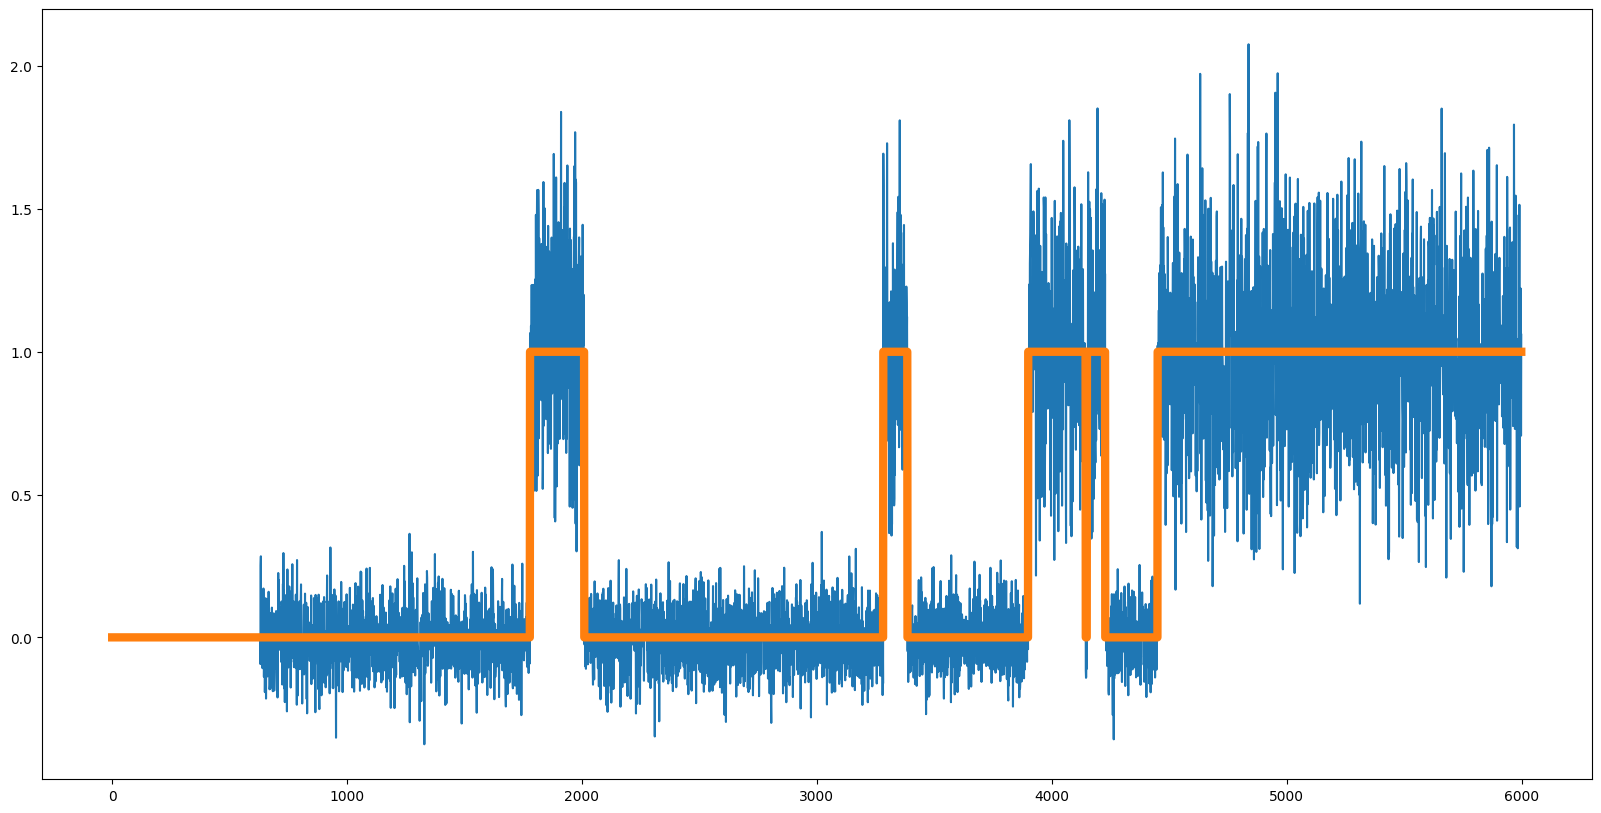

In [2]:
# plot the signal
signal, noised = generate(jumps=10)
plt.figure(figsize=(20, 10))
plt.plot(noised)
plt.plot(signal, linewidth=6)
plt.show()

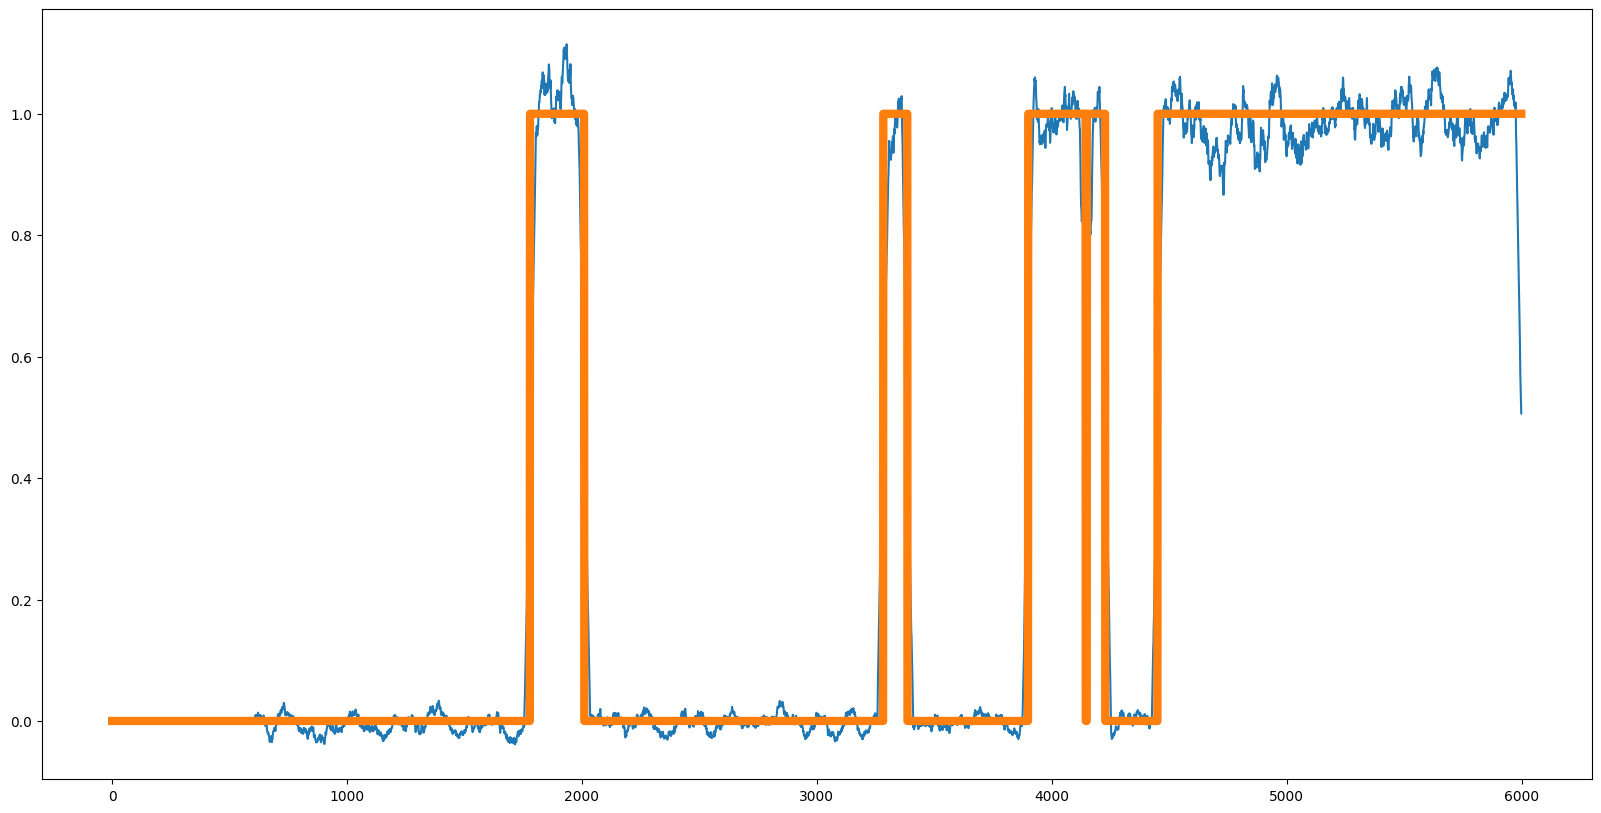

In [3]:
ma = moving_average(noised, 50)
plt.figure(figsize=(20, 10))
plt.plot(ma)
plt.plot(signal, linewidth=6)
plt.show()

In [35]:
# training and testing data with random number of jumps. Append moving average to the training data
train_X = []
train_y = []
test_X = []
test_y = []
for i in range(10000):
    jumps = np.random.randint(1, 20)
    signal, noised = generate(jumps=jumps)
    ma = moving_average(noised, 20)
    noised_and_ma = np.concatenate((noised, ma), axis=0)
    train_X.append(noised_and_ma)
    train_y.append(signal)
for i in range(10000):
    jumps = np.random.randint(1, 20)
    signal, noised = generate(jumps=jumps)
    ma = moving_average(noised, 20)
    noised_and_ma = np.concatenate((noised, ma), axis=0)
    test_X.append(noised_and_ma)
    test_y.append(signal)

train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

In [36]:
train_X.shape


(10000, 12000)

In [40]:
# a digital signal denoiser model
model = keras.Sequential(
    [
        keras.layers.Dense(60 * 100, activation="sigmoid"),
        keras.layers.Dense(60 * 100, activation="sigmoid"),
    ]
)
model.compile(optimizer="adam", loss="mse")


In [43]:

model.fit(
    np.array(train_X),
    np.array(train_y),
    epochs=10,
    batch_size=128,
    validation_data=(np.array(test_X), np.array(test_y)),
)

Epoch 1/10
79/79 [==============================] - 34s 418ms/step - loss: 0.0044 - val_loss: 0.0074
Epoch 2/10
79/79 [==============================] - 31s 392ms/step - loss: 0.0040 - val_loss: 0.0072
Epoch 3/10
79/79 [==============================] - 32s 407ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 4/10
79/79 [==============================] - 31s 391ms/step - loss: 0.0031 - val_loss: 0.0066
Epoch 5/10
79/79 [==============================] - 32s 404ms/step - loss: 0.0028 - val_loss: 0.0064
Epoch 6/10
79/79 [==============================] - 31s 388ms/step - loss: 0.0025 - val_loss: 0.0063
Epoch 7/10
79/79 [==============================] - 32s 402ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 8/10
79/79 [==============================] - 32s 401ms/step - loss: 0.0021 - val_loss: 0.0060
Epoch 9/10
79/79 [==============================] - 31s 385ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 10/10
79/79 [==============================] - 31s 388ms/step - loss: 0.0017 - val_lo

In [64]:
# plot the denoised signal with plotly
datapoint = 13
predicted = model.predict(np.array(test_X))[datapoint]
# if the predicted is below 0.5, it is 0, otherwise 1
predicted = np.where(predicted < 0.5, 0, 1)
actual = np.array(test_y)[datapoint]
fig = px.line(
    x=np.arange(0, 60, 0.01),
    y=predicted,
    title="Denoised Signal",
    labels={"x": "Time", "y": "Signal"},
)
fig.add_scatter(x=np.arange(0, 60, 0.01), y=actual, name="Actual Signal")
fig.add_scatter(x=np.arange(0, 60, 0.01), y=np.array(test_X)[datapoint], name="Noised Signal")
fig.show()

313/313 [==============================] - 13s 42ms/step


In [34]:
# save model
model.save("denoiser.keras")